<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Segmentation-ResNet34-in-FastAI" data-toc-modified-id="Segmentation-ResNet34-in-FastAI-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Segmentation ResNet34 in FastAI</a></span><ul class="toc-item"><li><span><a href="#Half-size:-128x800" data-toc-modified-id="Half-size:-128x800-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Half-size: 128x800</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Fine-tuning" data-toc-modified-id="Fine-tuning-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Fine-tuning</a></span></li></ul></li><li><span><a href="#Original-size:-256x1600" data-toc-modified-id="Original-size:-256x1600-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Original-size: 256x1600</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Fine-tuning" data-toc-modified-id="Fine-tuning-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Fine-tuning</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Validation-predictions" data-toc-modified-id="Validation-predictions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Validation predictions</a></span></li></ul></li></ul></div>

# Segmentation ResNet34 in FastAI

> Training notebook for this architecture.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from steel_segmentation.core import *
from steel_segmentation.data import *
from steel_segmentation.preprocessing import *
from steel_segmentation.models.dls import *
from steel_segmentation.models.metrics import *
from steel_segmentation.models.model import *

import fastai
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

In [ ]:
fastai.__version__

'2.2.3'

In [ ]:
torch.__version__

'1.7.1+cu101'

In [ ]:
torch.cuda.device_count(), torch.cuda.is_available()

(1, True)

In [ ]:
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Fri Jan 29 16:00:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   25C    P8     6W / 180W |     11MiB / 16278MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
print_competition_data(models_dir)

models/ResNet18-Unet-kaggle.pth
models/ResNet34-Unet-256-stage2.pth
models/ResNet34-Unet-256-stage1.pth
models/.ipynb_checkpoints
models/ResNet18-Classifier-kaggle.pth
models/ResNet34-Unet-256-stage3.pth
models/ResNet34-Unet-128-stage2.5.pth


Training a Unet model with `resnet34` encoder with progressive resizing.

In [ ]:
arch = resnet34

## Half-size: 128x800

In [ ]:
# bs = 8 # 8 gb
# bs = 16 # 16 gb
bs = 32 # 24 gb
szs = (128, 800)

In [ ]:
dls = get_segmentation_dls(bs, szs)

In [ ]:
x, y = dls.one_batch()
type(x), type(y), x.shape, y.shape

(fastai.torch_core.TensorImage,
 fastai.torch_core.TensorMask,
 (32, 3, 128, 800),
 (32, 128, 800))

In [ ]:
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)
segmentation_learner.model_dir = models_dir

### Training

In [ ]:
encoder_path = Path("models") / "ResNet34_class.pt"

In [ ]:
segmentation_learner.model[0].load_state_dict(torch.load(encoder_path), strict=True)

<All keys matched successfully>

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=6.30957365501672e-05)

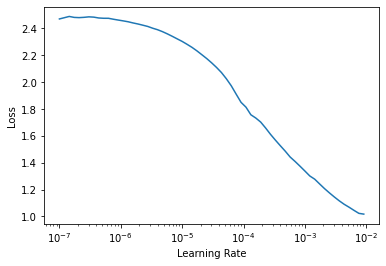

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage1
segmentation_learner.fit_one_cycle(10, lr_max=slice(3e-4, 3e-3))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.096990,0.083665,0.313438,0.854797,10:19


In [ ]:
#segmentation_learner.save("ResNet34-Unet-128-stage1")

In [ ]:
segmentation_learner.validate()

(#3) [0.04473937675356865,0.5976832730043088,0.9188908338546753]

SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=1.0964781722577754e-06)

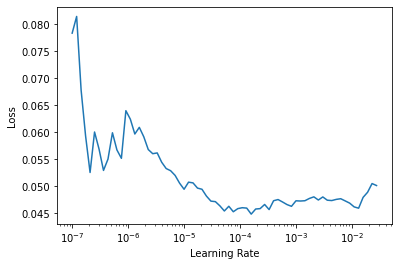

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage2
segmentation_learner.fit_one_cycle(5, lr_max=slice(3e-4, 3e-3))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.046489,0.057221,0.510095,0.904385,10:19
1,0.050522,0.048390,0.576426,0.916290,10:17
2,0.048738,0.046528,0.605400,0.915738,10:17
3,0.041545,0.044939,0.670970,0.917952,10:17
4,0.038927,0.043841,0.695421,0.921191,10:17


In [ ]:
segmentation_learner.save("ResNet34-Unet-128-stage2")

Path('models/ResNet34-Unet-128-stage2.pth')

In [ ]:
#segmentation_learner=segmentation_learner.load("ResNet34-Unet-128-stage2")

### Fine-tuning

In [ ]:
segmentation_learner.unfreeze()

SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=2.75422871709452e-06)

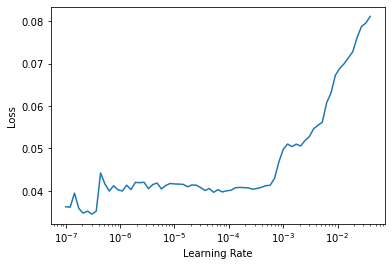

In [ ]:
segmentation_learner.lr_find()

In [ ]:
segmentation_learner.fit_one_cycle(5, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.039433,0.043197,0.699255,0.922506,07:53
1,0.040728,0.043263,0.702246,0.921859,07:50
2,0.040855,0.042848,0.704515,0.921778,07:49
3,0.039050,0.042759,0.707800,0.924741,07:49
4,0.039491,0.042418,0.708120,0.924275,07:49


In [ ]:
segmentation_learner.save("ResNet34-Unet-128-stage3")

Path('models/ResNet34-Unet-128-stage3.pth')

## Original-size: 256x1600

In [ ]:
bs = 4 # 16 gb
# bs = 8 # 24 gb

In [ ]:
dls = get_segmentation_dls(bs, (256, 1600))

In [ ]:
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)
segmentation_learner.model_dir = models_dir

### Training

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet34-Unet-128-stage3")

SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=6.309573450380412e-07)

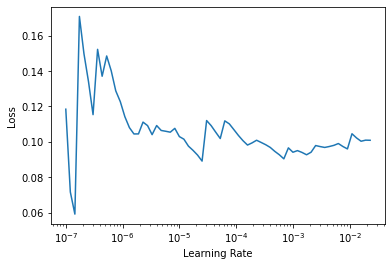

In [ ]:
segmentation_learner.lr_find()

Training for few epochs due GPU time limit with `GradientAccumulation` callback.

In [ ]:
# stage1
lr = slice(1e-4, 1e-3)
epochs = 3
segmentation_learner.fit_one_cycle(epochs, lr_max=lr, cbs=GradientAccumulation(bs*2))

epoch,train_loss,valid_loss,mod_dice_multi,dice_kaggle,time
0,0.065292,0.048253,0.650844,0.908896,31:08
1,0.058428,0.047692,0.684010,0.913800,30:57
2,0.048001,0.045992,0.685474,0.911532,30:57


In [ ]:
segmentation_learner.save("ResNet34-Unet-256-stage1")

Path('models/ResNet34-Unet-256-stage1.pth')

### Fine-tuning

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet34-Unet-256-stage3")

In [ ]:
segmentation_learner.summary()

DynamicUnet (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 128 x 800  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                      

In [ ]:
segmentation_learner.unfreeze()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=9.12010818865383e-07)

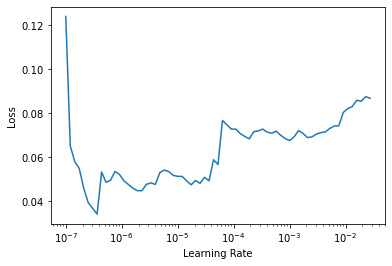

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage1
lr = slice(3e-6, 3e-5)
epochs = 4
segmentation_learner.fit_one_cycle(epochs, lr_max=lr, cbs=GradientAccumulation(bs*2))

epoch,train_loss,valid_loss,mod_dice_multi,dice_kaggle,time
0,0.066816,0.045675,0.705436,0.916705,45:53
1,0.048628,0.045439,0.704406,0.918792,45:42
2,0.049118,0.045072,0.707706,0.916294,45:39
3,0.051094,0.045032,0.715330,0.916313,45:40


In [ ]:
# stage1
lr = slice(3e-6, 3e-5)
epochs = 1
segmentation_learner.fit_one_cycle(epochs, lr_max=lr, cbs=GradientAccumulation(bs*2))

epoch,train_loss,valid_loss,mod_dice_multi,dice_kaggle,time
0,0.052788,0.045006,0.712420,0.917802,45:33


In [ ]:
segmentation_learner.save("ResNet34-Unet-256-stage5")

Path('models/ResNet34-Unet-256-stage5.pth')

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet34-Unet-256-stage5")

In [ ]:
segmentation_learner.summary()

DynamicUnet (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 128 x 800  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

In [ ]:
segmentation_learner.unfreeze()

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=7.585775847473997e-07)

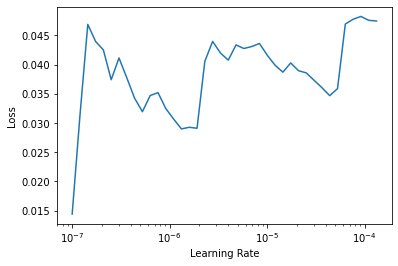

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage1
lr = slice(1e-6, 1e-5)
epochs = 3
segmentation_learner.fit_one_cycle(epochs, lr_max=lr, cbs=GradientAccumulation(bs*2))

epoch,train_loss,valid_loss,mod_dice_multi,dice_kaggle,time


## Results

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet34-Unet-256-stage1")

In [ ]:
segmentation_learner.validate()

(#3) [0.04599599167704582,0.6854738966965712,0.9115328788757324]

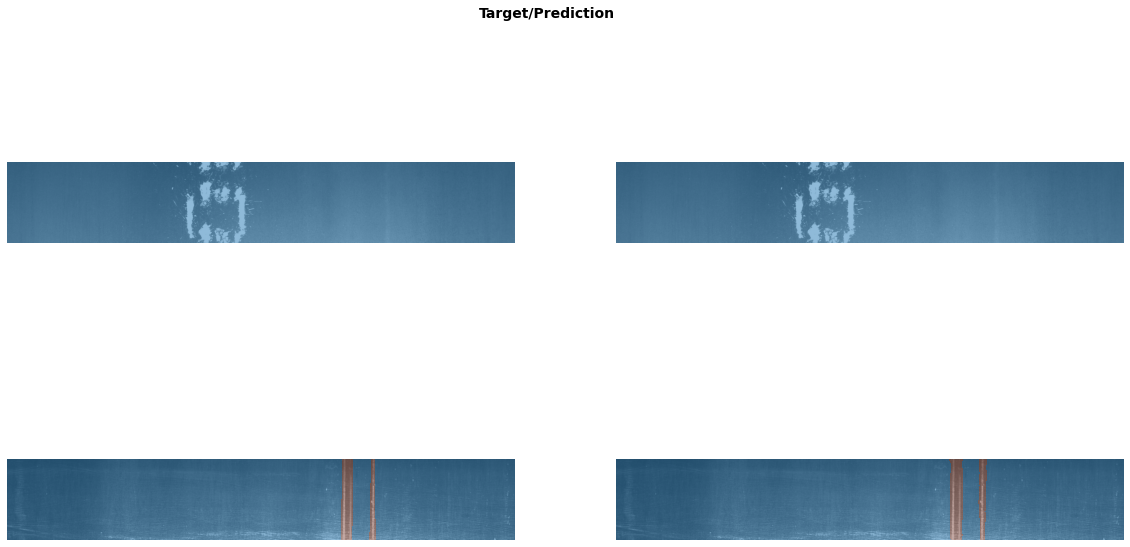

In [ ]:
segmentation_learner.show_results(figsize=(20,10))

## Validation predictions

*In italiano perché da sviluppare ancora*:

Per salvare gli output del modello è necessario:

1. fare inferenza sul validation set tramite il metodo `get_preds` (se si passa il parametro `with_decoded` permette di ottenere le probabilità invece dei digits).

2. Togliere i gradienti (se non è già stato fatto utilizzando `detach`) e convertire in un `np.array`.

3. Iterare su tutte le immagini, iterare per ogni immagine su ogni classe di difetto e utilizzare funzione `post_process` che filtra tutte le previsioni con pochi pixel data una certa soglia. 

4. Dalle maschere in `np.array` ottenute per ogni immagine, creare una codifica RLE utilizzando la funzione `mask2rle`.

5. Costruire il `pd.DataFrame` con le maschere codificate.

6. Costruire le maschere in formato `png` utilizzando la funzione `create_masks`.

Trovato il modo: utilizzare il metodo con il test set.

Trying to get the predictions for all the batches in the validation set. This worked for the 70% of the dataset but then a DataLoader worker (pid 6429) was killed (maybe because of memory).

In [ ]:
bs = 4

In [ ]:
dls = get_segmentation_dls(bs, (256, 1600), with_btfms=False)

In [ ]:
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)
segmentation_learner.model_dir = models_dir
segmentation_learner = segmentation_learner.load("ResNet34-Unet-256-stage1")

In [ ]:
pred_path = path.parent / "predictions"
pred_path.mkdir(parents=True, exist_ok=True)

In [ ]:
preds, targs = segmentation_learner.get_preds(with_decoded=True) 

RuntimeError: DataLoader worker (pid 6429) is killed by signal: Killed. 

Then I started working with a smaller size of dataset and dataloader but i need to mantain the same `TfmdDL`.

In [ ]:
valid_dl = dls.valid
valid_ds = valid_dl.dataset
size_fold = 100
elems = len(valid_ds)
folds = (elems // size_fold) + 1

In [ ]:
for nfold in range(folds):
    pass # loop

In [ ]:
nfold = 0

In [ ]:
start, end = (nfold*size_fold, (nfold+1)*size_fold)
    

In [ ]:
ds_fold = valid_ds[start:end]
dls.test_dl(test_items)
dl_fold = valid_dl.new(ds=ds_fold) # da valid_dl non funziona   

In [ ]:
len(ds_fold)

100

In [ ]:
len(new_dls)

629

In [ ]:
preds, _ = segmentation_learner.get_preds(dl=[x,y], with_input=True, with_decoded=True) 

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got 3-dimensional input of size [3, 256, 1600] instead